# Predicting User Churn for Sparkify Digital Music Service

This project involves working on a dataset from a digital music service, Sparkify, similar to Spotify or Pandora. Users interact with the platform daily, either through a free tier that includes advertisements or a premium, ad-free subscription model. Since users can upgrade, downgrade, or cancel their subscriptions at any time, retaining users is crucial for the business.

The goal of this project is to predict **user churn**—when a user either downgrades from premium to free or cancels the service entirely. By accurately identifying users likely to churn, the business can offer targeted discounts and incentives, helping to retain users and prevent revenue loss.

This notebook showcases the process, from data exploration and cleaning to feature engineering and model development, to build a predictive model for user churn.


In [198]:
import pandas as pd
file_path = 'mini_sparkify_event_data.json'
df = pd.read_json(file_path, lines=True)


### Key Insights from Initial Exploration

- The dataset includes `n` unique pages and interactions, covering both logged-in and non-logged-in user actions.
- There are significant numbers of missing values in columns like `location`, `artist`, and `song`, which may indicate interactions unrelated to music streaming.
- The timestamps are stored in Unix format, which we’ll convert to a readable datetime format for better interpretation.


### Dataset Column Descriptions

The following table provides an overview of each column in the dataset and describes the data it contains.

| Column          | Description                                                                                           |
|-----------------|-------------------------------------------------------------------------------------------------------|
| `ts`            | Timestamp of each interaction, recorded in Unix time and indicating when the event occurred           |
| `userId`        | Unique identifier assigned to each user                                                               |
| `sessionId`     | Unique identifier for each session, representing a continuous period of user activity                 |
| `page`          | Type of action taken by the user (e.g., "NextSong," "Thumbs Up," "Logout," "Cancellation Confirmation") |
| `auth`          | Authentication status indicating user access level, such as "Logged In," "Logged Out," or "Guest"     |
| `method`        | HTTP method used in the request (e.g., "GET" or "PUT")                                                |
| `status`        | Status code of the HTTP request (e.g., 200 for success, 307 for redirection, 404 for not found)       |
| `level`         | User account level indicating access tier: "free" or "paid"                                           |
| `itemInSession` | Position of the interaction within the current session, tracking the order of events in each session  |
| `location`      | Location of the user based on city and state (e.g., "San Francisco, CA")                              |
| `userAgent`     | Browser and operating system information of the user                                                  |
| `lastName`      | Last name of the user                                                                                 |
| `firstName`     | First name of the user                                                                                |
| `registration`  | Timestamp indicating when the user first registered                                                   |
| `gender`        | Gender of the user, represented as "M" for male or "F" for female                                     |
| `artist`        | Name of the artist associated with the streamed song (if the interaction is a music streaming event)  |
| `song`          | Title of the song streamed by the user (if the interaction is a music streaming event)                |
| `length`        | Duration of the streamed song in seconds (if the interaction is a music streaming event)              |



### Dataset Column Descriptions

The following table provides an overview of key columns in the dataset, organized by interaction type. This helps clarify the purpose of each column and the data it contains.

| Interaction Type       | Column          | Description                                                   |
|------------------------|-----------------|---------------------------------------------------------------|
| **Streaming Activity** | `song`          | Title of the song streamed by the user                        |
|                        | `artist`        | Name of the artist of the streamed song                       |
|                        | `length`        | Duration of the streamed song in seconds                      |
|                        | `page`          | Page or event, e.g., "NextSong" indicating a song was played  |
| **Account Interactions** | `userId`       | Unique identifier for each user                               |
|                        | `sessionId`     | ID for each session the user initiates                        |
|                        | `auth`          | Authentication status, e.g., "Logged In" or "Cancelled"       |
|                        | `level`         | User account level: "free" or "paid"                          |
|                        | `ts`            | Timestamp of each action                                      |
| **Engagement Metrics** | `page`          | Tracks interactions like "Thumbs Up" or "Thumbs Down"         |
|                        | `itemInSession` | Tracks the order of actions within a session                  |
| **Ad Impressions**     | `page`          | Tracks ads encountered on "Roll Advert" page for free users   |
| **User Information**   | `location`      | User location in "City, State" format                         |
|                        | `userAgent`     | User’s browser and OS information                             |
|                        | `firstName`     | User’s first name                                             |
|                        | `lastName`      | User’s last name                                              |
|                        | `registration`  | Timestamp when the user registered                            |
|                        | `gender`        | User’s gender: "M" or "F"                                     |



In [199]:
# Unique values in categorical columns
unique_values = {col: df[col].unique() for col in ['page', 'auth', 'method', 'status', 'level', 'gender']}
unique_values


{'page': array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
        'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Login',
        'Upgrade', 'Add Friend', 'About', 'Settings', 'Submit Upgrade',
        'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
        'Cancellation Confirmation', 'Register', 'Submit Registration'],
       dtype=object),
 'auth': array(['Logged In', 'Logged Out', 'Cancelled', 'Guest'], dtype=object),
 'method': array(['PUT', 'GET'], dtype=object),
 'status': array([200, 307, 404], dtype=int64),
 'level': array(['paid', 'free'], dtype=object),
 'gender': array(['M', 'F', nan], dtype=object)}

In [200]:
# Convert timestamps to datetime
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
df['registration'] = pd.to_datetime(df['registration'], unit='ms')

# Format other columns (as needed, e.g., stripping whitespace)
df['userAgent'] = df['userAgent'].str.strip()


C:\Users\tully\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:530: RuntimeWarning: invalid value encountered in cast
  arr, tz_parsed = tslib.array_with_unit_to_datetime(arg, unit, errors=errors)


In [201]:
# Check the total number of rows in the dataset
total_rows = df.shape[0]
total_rows


286500

### Filtering Out Non-Logged-In Users

In this dataset, there are interactions from users who did not log into the platform and are simply browsing the website. These interactions include visiting pages like "Home," "Help," "Login," and "About." Since these interactions do not represent active, engaged users streaming content, we will filter out these rows to focus our analysis on logged-in users who interact meaningfully with the platform.


In [202]:
# Identify non-logged-in interactions
non_logged_in = df[(df['auth'] == 'Logged Out') | (df['auth'] == 'Guest')]

# Display count of non-logged-in interactions
print("Number of non-logged-in interactions:", non_logged_in.shape[0])

# Filter out these rows from the main dataset
df_filtered = df[~((df['auth'] == 'Logged Out') | (df['auth'] == 'Guest'))]
print("Number of remaining logged-in interactions:", df_filtered.shape[0])


Number of non-logged-in interactions: 8346
Number of remaining logged-in interactions: 278154


### Summary

After filtering out the non-logged-in interactions, our dataset now focuses exclusively on active, engaged users who have logged into the platform. This allows for a more targeted analysis of user behavior and engagement with music content, excluding interactions from brief visitors or casual browsers.


### Defining Churn

In this analysis, **churn** is defined as any user who reaches the `"Cancellation Confirmation"` page, indicating they have canceled their service. By identifying these users, we can better understand factors that lead to churn and develop strategies to retain users.


In [203]:
# Create a churn flag: 1 for churned users, 0 for non-churned users
df_filtered['churn'] = df_filtered['page'].apply(lambda x: 1 if x == 'Cancellation Confirmation' else 0)

# Check how many churn events are present
churn_count = df_filtered['churn'].sum()
print("Number of churned users:", churn_count)
df = df_filtered

Number of churned users: 52


C:\Users\tully\AppData\Local\Temp\ipykernel_42036\3428388923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['churn'] = df_filtered['page'].apply(lambda x: 1 if x == 'Cancellation Confirmation' else 0)


### Churn Flag Summary

The `"churn"` column now flags users who have canceled their service. There are **52 churn events** in our dataset. This flag will be essential for further analysis, allowing us to compare behaviors between churned and retained users.


### Distribution of Account Levels

This bar chart shows the distribution of Sparkify users across two account levels: "paid" and "free." The majority of users are on the paid tier, as indicated by the significantly taller blue bar compared to the yellow bar representing free-tier users. This imbalance highlights Sparkify's primary user base, which may be more invested in the platform due to their paid status.

Understanding the proportion of paid versus free users is essential for tailoring retention strategies, as the factors influencing churn might differ for each group. For instance, free users may be more sensitive to ad exposure, while paid users might churn due to insufficient value from the premium experience.


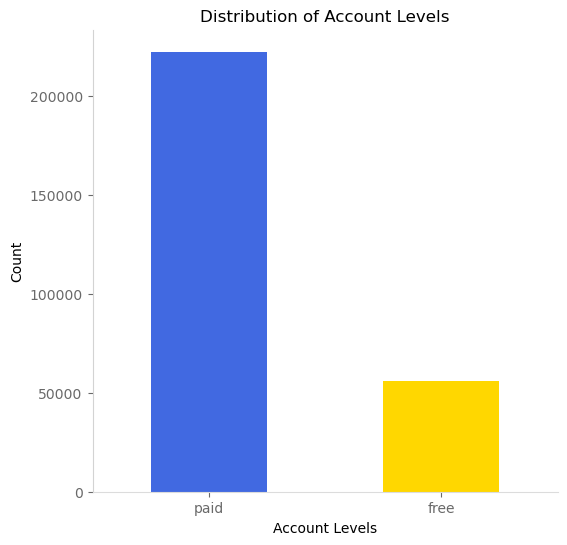

In [204]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

plt.figure(figsize=(6, 6))
df['level'].value_counts().plot(kind='bar', color=['royalblue', 'gold'])
plt.title('Distribution of Account Levels')
plt.xlabel('Account Levels')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Optional: to make the x-axis labels horizontal
# Remove the top and right spines for a cleaner look
sns.despine()
# Set colors for the plot's spines and ticks
plt.gca().spines['bottom'].set_color('gainsboro')
plt.gca().spines['left'].set_color('lightgrey')
plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')
plt.xlabel("Account Levels", color='black')
plt.ylabel("Count", color='black')
plt.title("Distribution of Account Levels", color='black')

plt.show()


### User Activity Over Time (Daily)

This line plot illustrates daily user interactions on the Sparkify platform, with a focus on identifying trends and patterns in user engagement. The highlighted yellow vertical bands mark weekends, where we observe fluctuations in user activity. While weekdays generally show consistent engagement, weekends display a mix of higher and lower activity levels, possibly indicating varied user behavior based on free time and leisure patterns.

Monitoring these activity patterns can help Sparkify identify optimal times for promotions or targeted content delivery, potentially boosting engagement during low-activity periods.


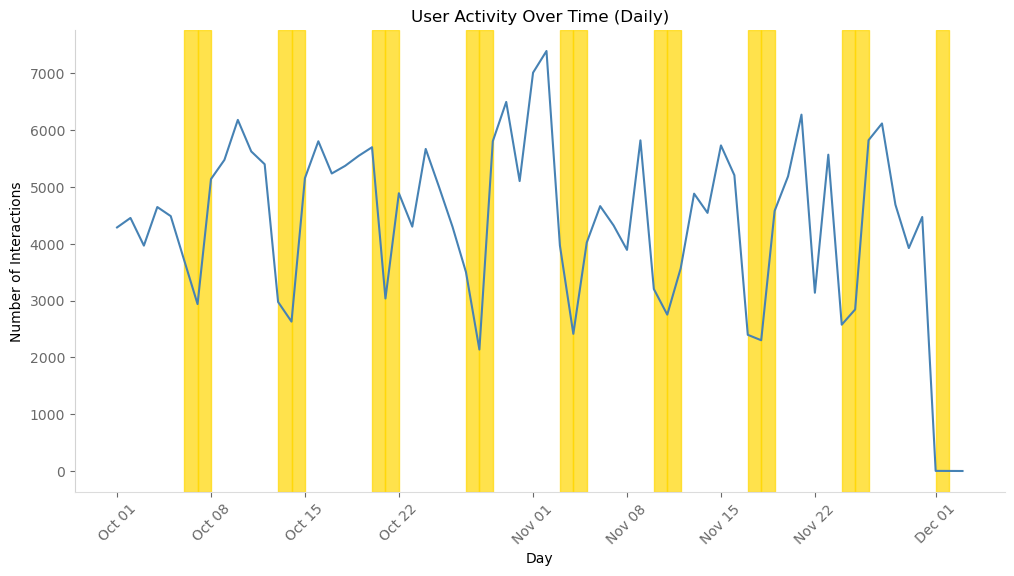

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates


# Create the daily activity plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=daily_activity.index, y=daily_activity.values, color='steelblue')
plt.title("User Activity Over Time (Daily)")
plt.xlabel("Day")
plt.ylabel("Number of Interactions")

# Format the x-axis ticks to show only "Oct 1" style without the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=45)

# Highlight weekends
for day in daily_activity.index:
    if day.weekday() >= 5:  # Saturday (5) and Sunday (6)
        plt.axvspan(day, day + pd.Timedelta(days=1), color='gold', alpha=0.7)

# Remove the top and right spines for a cleaner look
sns.despine()

# Set the axis colors to light grey
plt.gca().spines['bottom'].set_color('gainsboro')
plt.gca().spines['left'].set_color('lightgrey')
plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')
plt.xlabel("Day", color='black')
plt.ylabel("Number of Interactions", color='black')
plt.title("User Activity Over Time (Daily)", color='black')  # Optional: make the title a darker grey

plt.show()


### Hourly User Activity

This bar chart displays the distribution of user interactions throughout the day, highlighting peak engagement times on the Sparkify platform. User activity steadily rises from the early morning hours, peaking around the late afternoon (4-5 PM) and early evening (6-7 PM) before tapering off at night. This pattern suggests that users are most active during post-work or leisure hours, providing an ideal window for Sparkify to target engagement initiatives, such as recommending new playlists or offering limited-time promotions.

Understanding these hourly patterns can help Sparkify optimize content delivery and enhance user retention by aligning with users' natural engagement times.


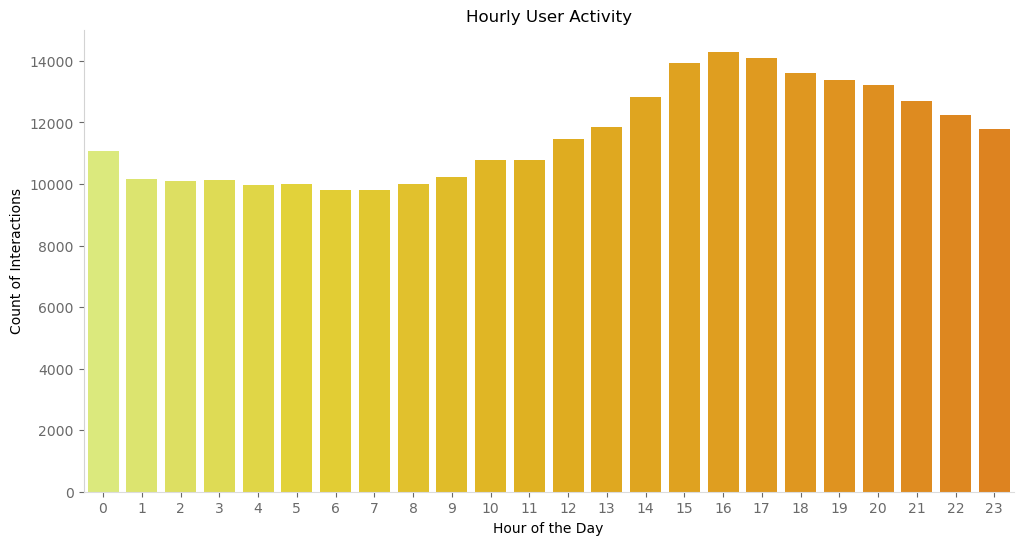

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'ts' is in milliseconds and 'df' is already defined
df['datetime'] = pd.to_datetime(df['ts'], unit='ms')
df['hour'] = df['datetime'].dt.hour

# Create the count plot
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='hour', palette="Wistia")
plt.title('Hourly User Activity')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Interactions')

# Remove the top and right spines for a cleaner look
sns.despine()

# Set the axis colors to light grey
plt.gca().spines['bottom'].set_color('gainsboro')
plt.gca().spines['left'].set_color('lightgrey')
plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')

# Show the plot
plt.show()


### Distribution of Event Age (Days Since Registration)

This histogram shows the distribution of user events based on the number of days since registration. The data reveals that user engagement is highest within the first 50 days of joining Sparkify, with a gradual decline in activity as users progress beyond this period. After around 100 days, engagement levels drop significantly, with only a small number of interactions occurring after 150 days.

This trend highlights the importance of early engagement for user retention. Sparkify could benefit from implementing targeted retention strategies during this critical initial period, such as offering personalized recommendations, incentives, or tutorials to enhance user satisfaction and encourage long-term loyalty.


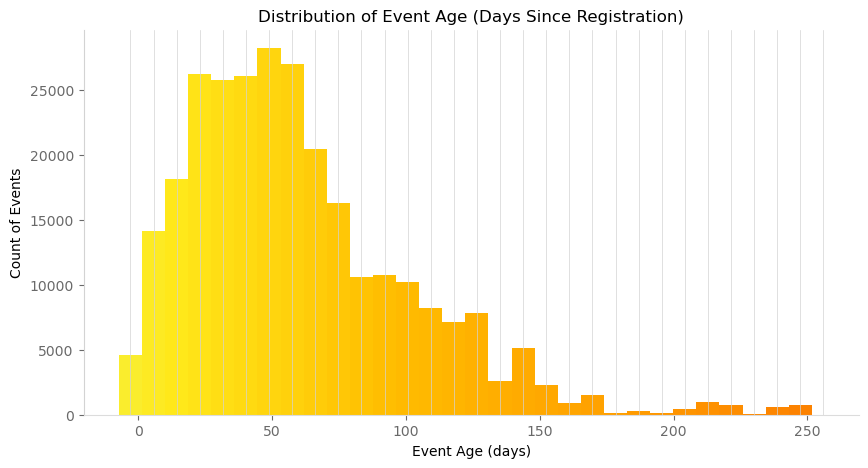

In [207]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Ensure 'ts' and 'registration' are in datetime format
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
df['registration'] = pd.to_datetime(df['registration'], unit='ms')

# Calculate event age in days (using vectorized operation)
df['event_age'] = (df['ts'] - df['registration']).dt.days

# Prepare data for plotting
data = df['event_age'].dropna()
bins = 30
counts, bin_edges = np.histogram(data, bins=bins)

# Plot histogram with gradient effect and grey lines between bins
plt.figure(figsize=(10, 5))
ax = plt.gca()  # Get current axes

# Add light grey vertical lines between bins
for edge in bin_edges:
    plt.axvline(x=edge, color='lightgrey', linestyle='-', linewidth=0.5)

# Plot the bars with a blue gradient, avoiding starting with white
for i in range(bins):
    plt.bar(
        bin_edges[i], counts[i],
        width=bin_edges[i+1] - bin_edges[i],
        color=plt.cm.Wistia(0.2 + (i / bins) * 0.8)  # Start from 0.2 to avoid white
    )

# Add titles and labels
plt.title("Distribution of Event Age (Days Since Registration)")
plt.xlabel("Event Age (days)")
plt.ylabel("Count of Events")

# Remove the top and right spines for a cleaner look
sns.despine()

# Set the axis colors to light grey
plt.gca().spines['bottom'].set_color('gainsboro')
plt.gca().spines['left'].set_color('lightgrey')
plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')

# Show the plot
plt.show()


### Average Number of Ads Encountered per User by User Level

This bar chart highlights the stark difference in ad exposure between free and paid users on the Sparkify platform. Free-tier users encounter a significantly higher number of ads on average compared to paid users, who experience minimal to no ads. This substantial gap underscores the incentive for users to upgrade to a paid subscription for an ad-free experience.

However, the high ad frequency for free users may also risk increased churn if ad exposure is perceived as overwhelming. Sparkify could consider optimizing ad frequency or testing alternative ad formats for free users to improve the user experience and potentially reduce churn.


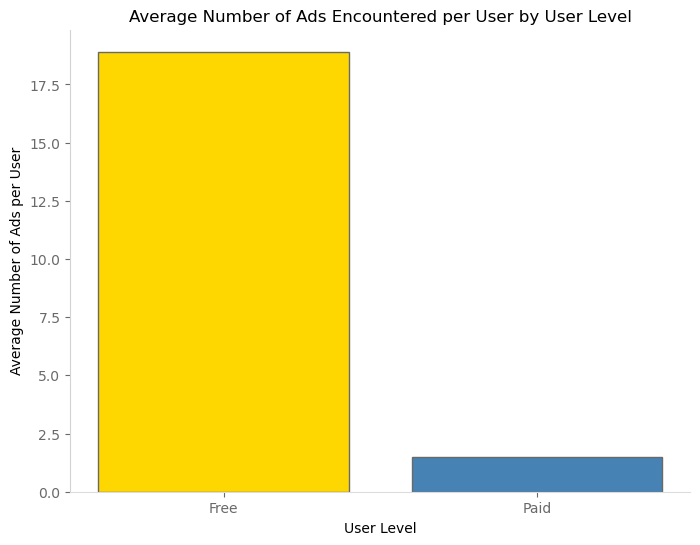

In [208]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare data for plotting
ads_data_plot = pd.DataFrame({
    'User Level': ['Free', 'Paid'],
    'Average Ads per User': [average_ads_free, average_ads_paid]
})

# Plotting the data using Matplotlib
plt.figure(figsize=(8, 6))
plt.bar(ads_data_plot['User Level'], ads_data_plot['Average Ads per User'], color=['gold', 'steelblue'], edgecolor='dimgrey')

# Titles and labels
plt.title("Average Number of Ads Encountered per User by User Level", color='black')
plt.xlabel("User Level", color='black')
plt.ylabel("Average Number of Ads per User", color='black')

# Customize spines and tick colors
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_color('gainsboro')
plt.gca().spines['left'].set_color('lightgrey')
plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')

# Show the plot
plt.show()


### Days Until Churn by Subscription Level

This histogram shows the distribution of days until churn, segmented by subscription level (paid vs. free). The data reveals that free users tend to churn earlier than paid users, as indicated by the orange curve peaking sooner. Paid users, represented by the blue curve, show a longer duration before churn, with a peak around 50 days.

This pattern suggests that paid users are more engaged initially but may still be at risk of churning after several months. Sparkify can use this insight to create timely retention strategies, such as offering engagement incentives to free users early on and introducing loyalty rewards or exclusive content for paid users around the 50-day mark to sustain their commitment.


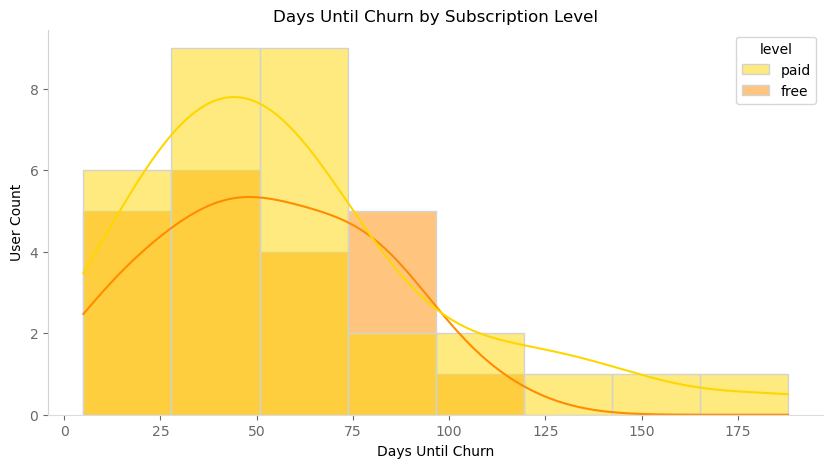

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter for churned users and create a copy
churned_users = df[df['churn'] == 1].copy()

# Ensure 'ts' and 'registration' columns are in datetime format if they aren't already
churned_users['ts'] = pd.to_datetime(churned_users['ts'], unit='ms')
churned_users['registration'] = pd.to_datetime(churned_users['registration'], unit='ms')

# Calculate days until churn in a vectorized manner
churned_users['days_until_churn'] = (churned_users['ts'] - churned_users['registration']).dt.days

# Plot the histogram for days until churn by subscription level
plt.figure(figsize=(10, 5))
sns.histplot(
    data=churned_users, 
    x='days_until_churn', 
    hue='level', 
    kde=True, 
    palette={'paid': 'gold', 'free': 'darkorange'}, 
    edgecolor='lightgrey'  # Set bar outlines to dimgrey
)
plt.title("Days Until Churn by Subscription Level")
plt.xlabel("Days Until Churn")
plt.ylabel("User Count")

# Remove the top and right spines for a cleaner look
sns.despine()

# Set the axis colors to light grey
plt.gca().spines['bottom'].set_color('gainsboro')
plt.gca().spines['left'].set_color('lightgrey')
plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')

# Show the plot
plt.show()


In [210]:
import pandas as pd

# Step 1: Ensure 'ts' is in datetime format (if not already)
df['ts'] = pd.to_datetime(df['ts'], unit='ms')

# Step 2: Calculate the last activity for each user
user_last_activity = df.groupby('userId')['ts'].max().reset_index()
user_last_activity.rename(columns={'ts': 'last_activity'}, inplace=True)

# Step 3: Merge 'last_activity' back to the original DataFrame
df = df.merge(user_last_activity, on='userId', how='left')


In [211]:
# Convert 'ts' to datetime if not already done
df['ts'] = pd.to_datetime(df['ts'], unit='ms')

# Find the earliest and latest timestamps
start_date = df['ts'].min()
end_date = df['ts'].max()

print(f"Data Timeline: {start_date} to {end_date}")


Data Timeline: 2018-10-01 00:01:57 to 2018-12-03 01:11:16


In [219]:
# Filter the dataset for "Roll Advert" events (ads)
ads_data = df[df['page'] == 'Roll Advert']

# Count the number of ads encountered by each user level (free vs paid)
ads_by_level = ads_data.groupby('level').size()

# Display the results
print("Number of ads encountered by user level:")
print(ads_by_level)


Number of ads encountered by user level:
level
free    3687
paid     246
dtype: int64


In [213]:
# Calculate the total number of free and paid users
free_users_count = df[df['level'] == 'free']['userId'].nunique()
paid_users_count = df[df['level'] == 'paid']['userId'].nunique()

# Calculate the average number of ads per user for free and paid users
average_ads_free = ads_by_level['free'] / free_users_count
average_ads_paid = ads_by_level['paid'] / paid_users_count

# Display the results
print(f"Average number of ads encountered per free user: {average_ads_free:.2f}")
print(f"Average number of ads encountered per paid user: {average_ads_paid:.2f}")


Average number of ads encountered per free user: 18.91
Average number of ads encountered per paid user: 1.49


### User Actions by Subscription Level (Key Actions)

This bar chart displays the distribution of specific user actions—"Add Friend," "Add to Playlist," "Roll Advert," "Thumbs Down," and "Thumbs Up"—across different subscription levels: free and paid.

- **Add Friend and Add to Playlist**: These interactive features are significantly more common among paid users than free users. This trend suggests that paid users tend to engage more with the platform by actively curating their playlists and building social connections.

- **Roll Advert**: This action is exclusive to free users, as it represents the advertisements encountered during the user experience. The high count for free users aligns with the platform's monetization strategy, where advertisements are a primary feature of the free tier.

- **Thumbs Down and Thumbs Up**: Paid users also demonstrate a higher frequency of giving positive (and slightly more negative) feedback through "Thumbs Up" and "Thumbs Down" interactions. This suggests that paid users are more invested in shaping their music recommendations or expressing preferences on the platform.

Overall, the chart reveals distinct engagement patterns between free and paid users. Paid users appear to be more engaged with interactive features and more willing to provide feedback, which could indicate greater satisfaction or a more personalized experience. Meanwhile, the "Roll Advert" frequency highlights a potential point of friction for free users, possibly impacting their overall experience.


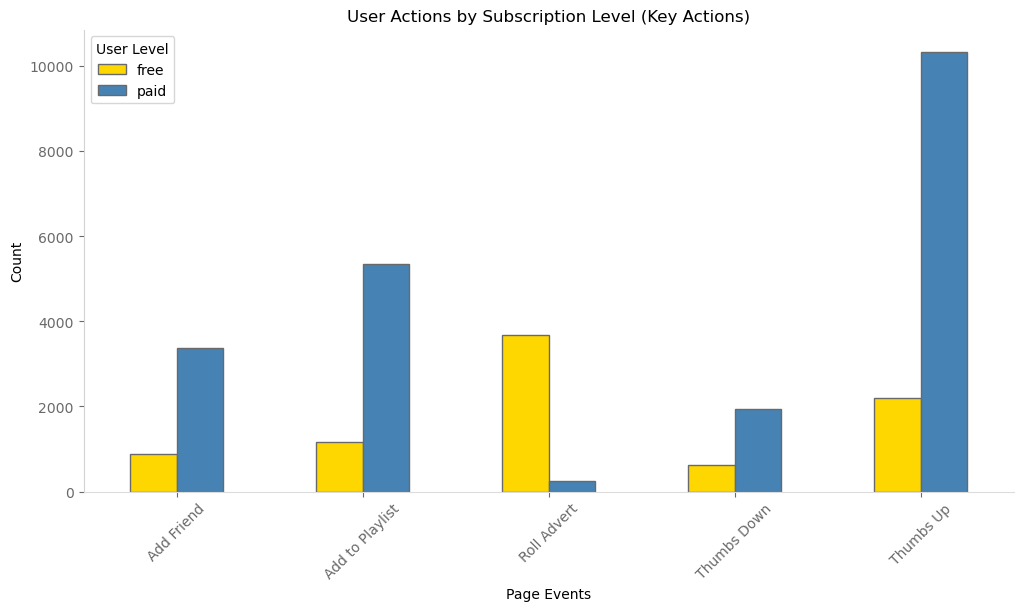

In [214]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' contains the data with 'page' and 'level' columns.

# Define key actions to analyze
key_actions = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Roll Advert', 'Add Friend']

# Filter data for key actions and group by 'page' and 'level'
action_counts = df[df['page'].isin(key_actions)].groupby(['page', 'level']).size().unstack().fillna(0)

# Plotting the grouped bar chart
plt.figure(figsize=(12, 6))
action_counts.plot(kind='bar', color=['gold', 'steelblue'], edgecolor='dimgrey', ax=plt.gca())

# Titles and labels
plt.title("User Actions by Subscription Level (Key Actions)", color='black')
plt.xlabel("Page Events", color='black')
plt.ylabel("Count", color='black')
plt.xticks(rotation=45)

# Customize spines and tick colors
sns.despine()
plt.gca().spines['bottom'].set_color('gainsboro')
plt.gca().spines['left'].set_color('lightgrey')
plt.gca().tick_params(axis='x', colors='dimgrey')
plt.gca().tick_params(axis='y', colors='dimgrey')

# Show the plot
plt.legend(title='User Level')
plt.show()


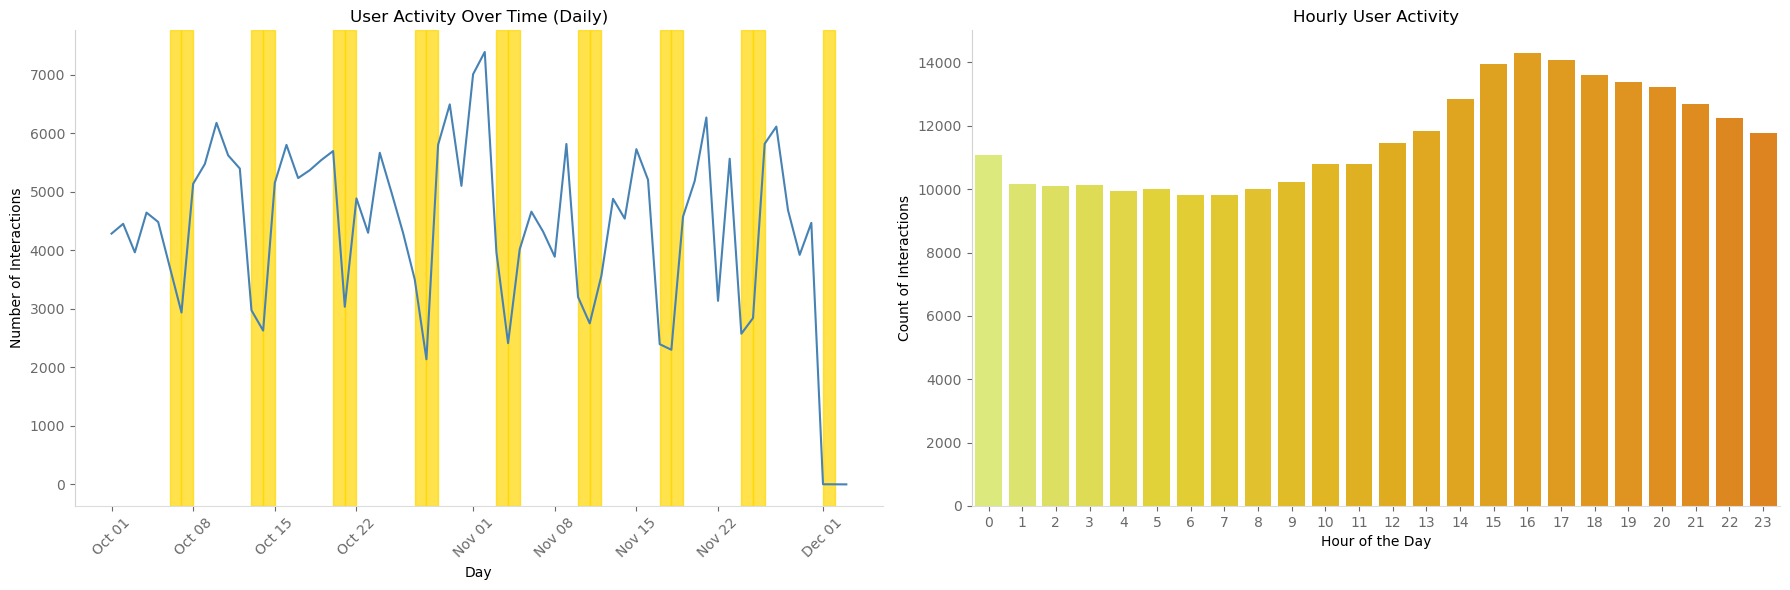

In [239]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.dates as mdates

# Sample data for demonstration
# Assuming daily_activity and df['ts'] are defined
# daily_activity = pd.Series(...)
# df = pd.DataFrame(...)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Daily Activity Over Time
sns.lineplot(ax=axes[0], x=daily_activity.index, y=daily_activity.values, color='steelblue')
axes[0].set_title("User Activity Over Time (Daily)", color='black')
axes[0].set_xlabel("Day", color='black')
axes[0].set_ylabel("Number of Interactions", color='black')
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
axes[0].tick_params(axis='x', rotation=45, colors='dimgrey')
axes[0].tick_params(axis='y', colors='dimgrey')
sns.despine(ax=axes[0])
axes[0].spines['bottom'].set_color('gainsboro')
axes[0].spines['left'].set_color('lightgrey')

# Highlight weekends on the daily activity plot
for day in daily_activity.index:
    if day.weekday() >= 5:
        axes[0].axvspan(day, day + pd.Timedelta(days=1), color='gold', alpha=0.7)

# Plot 2: Hourly User Activity
df['datetime'] = pd.to_datetime(df['ts'], unit='ms')
df['hour'] = df['datetime'].dt.hour
sns.countplot(ax=axes[1], data=df, x='hour', palette="Wistia")
axes[1].set_title('Hourly User Activity', color='black')
axes[1].set_xlabel('Hour of the Day', color='black')
axes[1].set_ylabel('Count of Interactions', color='black')
sns.despine(ax=axes[1])
axes[1].spines['bottom'].set_color('gainsboro')
axes[1].spines['left'].set_color('lightgrey')
axes[1].tick_params(axis='x', colors='dimgrey')
axes[1].tick_params(axis='y', colors='dimgrey')

plt.tight_layout()
plt.show()


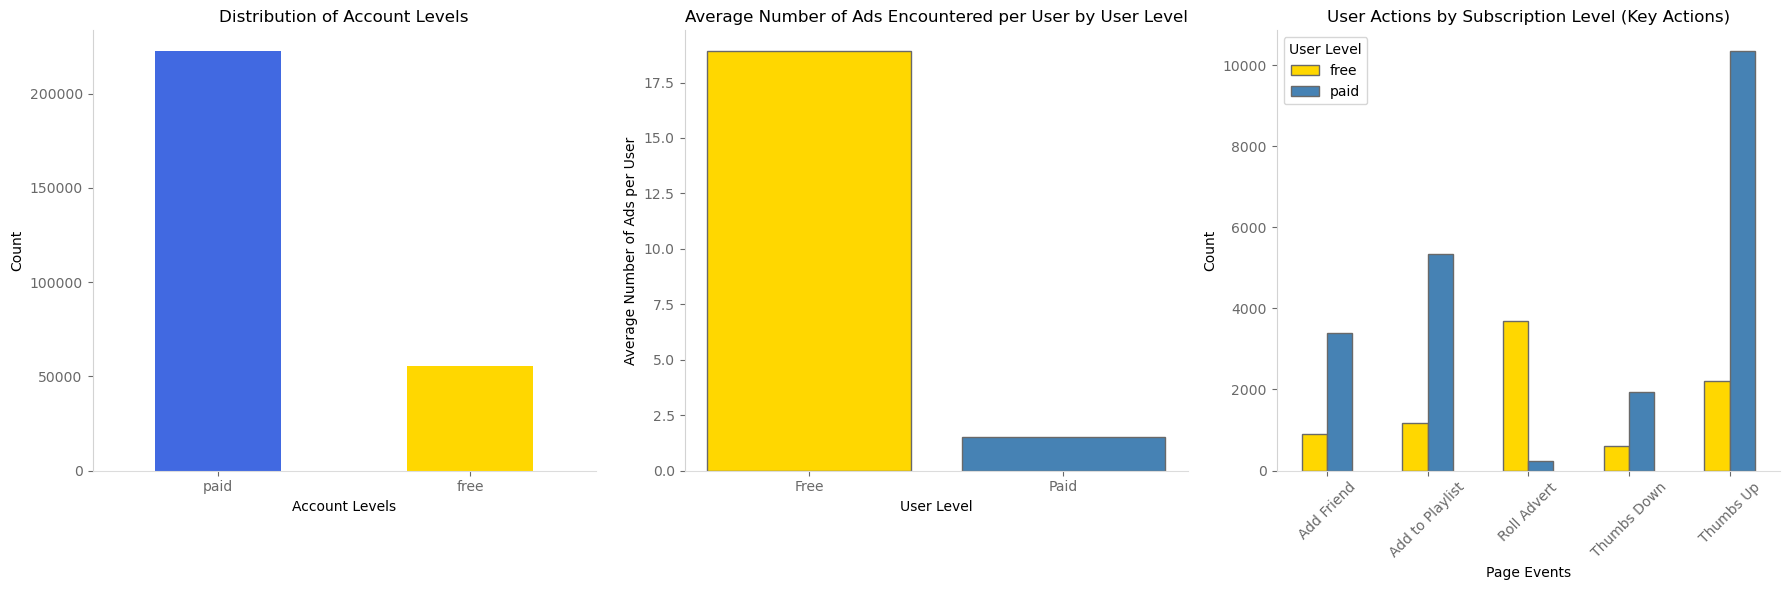

In [238]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Sample data for demonstration
# Assuming df, average_ads_free, and average_ads_paid are defined
# df = pd.DataFrame({'level': [...], 'page': [...]})
# average_ads_free = ...
# average_ads_paid = ...

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Distribution of Account Levels
df['level'].value_counts().plot(kind='bar', color=['royalblue', 'gold'], ax=axes[0])
axes[0].set_title('Distribution of Account Levels', color='black')
axes[0].set_xlabel('Account Levels', color='black')
axes[0].set_ylabel('Count', color='black')
axes[0].tick_params(axis='x', rotation=0, colors='dimgrey')
axes[0].tick_params(axis='y', colors='dimgrey')
sns.despine(ax=axes[0])
axes[0].spines['bottom'].set_color('gainsboro')
axes[0].spines['left'].set_color('lightgrey')

# Plot 2: Average Ads per User by User Level
ads_data_plot = pd.DataFrame({
    'User Level': ['Free', 'Paid'],
    'Average Ads per User': [average_ads_free, average_ads_paid]
})
axes[1].bar(ads_data_plot['User Level'], ads_data_plot['Average Ads per User'], color=['gold', 'steelblue'], edgecolor='dimgrey')
axes[1].set_title("Average Number of Ads Encountered per User by User Level", color='black')
axes[1].set_xlabel("User Level", color='black')
axes[1].set_ylabel("Average Number of Ads per User", color='black')
sns.despine(ax=axes[1])
axes[1].spines['bottom'].set_color('gainsboro')
axes[1].spines['left'].set_color('lightgrey')
axes[1].tick_params(axis='x', colors='dimgrey')
axes[1].tick_params(axis='y', colors='dimgrey')

# Plot 3: User Actions by Subscription Level (Key Actions)
key_actions = ['Thumbs Up', 'Thumbs Down', 'Add to Playlist', 'Roll Advert', 'Add Friend']
action_counts = df[df['page'].isin(key_actions)].groupby(['page', 'level']).size().unstack().fillna(0)
action_counts.plot(kind='bar', color=['gold', 'steelblue'], edgecolor='dimgrey', ax=axes[2])
axes[2].set_title("User Actions by Subscription Level (Key Actions)", color='black')
axes[2].set_xlabel("Page Events", color='black')
axes[2].set_ylabel("Count", color='black')
axes[2].tick_params(axis='x', rotation=45, colors='dimgrey')
axes[2].tick_params(axis='y', colors='dimgrey')
sns.despine(ax=axes[2])
axes[2].spines['bottom'].set_color('gainsboro')
axes[2].spines['left'].set_color('lightgrey')
axes[2].legend(title='User Level')

plt.tight_layout()
plt.show()


### Key Features for Predicting User Churn

To better understand and predict user churn, we engineered a rich set of features that capture user behavior, engagement, and account activity. Here’s a quick snapshot of our most insightful features:

- **Session Patterns**  
  - **Total Sessions**: Number of distinct sessions per user.
  - **Average Session Duration**: How long users typically stay active per session.
  - **Average Time Between Sessions**: Frequency of user returns, hinting at loyalty or early signs of disengagement.

- **Music Engagement**  
  - **Total Songs Played**: How much users listen, reflecting their overall engagement.
  - **Skip Ratio**: How often users skip songs, potentially indicating dissatisfaction with recommendations.
  - **Discovery Engagement Ratio**: Engagement with discovery features like "Add Friend" and "Add to Playlist," showing user interest in exploration.

- **Social & Interactive Behavior**  
  - **Total Thumbs Up / Thumbs Down**: Feedback given by users, signaling satisfaction or frustration.
  - **Total Add to Playlist**: A measure of user interest in saving or revisiting songs.
  - **Total Social Interactions**: Friend connections, showing social engagement on the platform.

- **Account & Subscription Status**  
  - **User Level**: Free vs. paid tier indicator, critical for analyzing ad exposure and user experience differences.
  - **Total Downgrades & Cancelled Status**: Actions taken by users to downgrade or cancel, directly tied to churn risk.

- **Ad Interaction**  
  - **Total Roll Adverts**: Ads encountered by free users, a potential churn factor.
  - **Ad Interaction Rate**: Frequency of ad exposure per free user, reflecting ad impact on user experience.

- **Engagement Timing**  
  - **Peak Hour Activity**: Favorite time of day for user activity, helpful for targeted interventions.
  - **Weekend Engagement Ratio**: Engagement on weekends vs. weekdays, hinting at behavioral patterns based on user schedules.

- **Tenure & Activity Trends**  
  - **Days Since Last Activity**: Time since users were last active, signaling the risk of churn if they haven’t returned.
  - **Recent Level Change**: Recent subscription changes, revealing any shifts in satisfaction or spending behavior.


In [ ]:
import pandas as pd
import numpy as np

# Ensure 'ts' is in datetime format
df['ts'] = pd.to_datetime(df['ts'], unit='ms')
df['registration'] = pd.to_datetime(df['registration'], unit='ms')

# Basic Features
# 1. Total Sessions per User
total_sessions = df.groupby('userId')['sessionId'].nunique().rename('total_sessions')

# 2. Average Session Activity
avg_session_activity = df.groupby(['userId', 'sessionId']).size().groupby('userId').mean().rename('avg_session_activity')

# 3. Total Songs Played
total_songs_played = df[df['page'] == 'NextSong'].groupby('userId').size().rename('total_songs_played')

# 4. Average Song Length
avg_song_length = df.groupby('userId')['length'].mean().fillna(0).rename('avg_song_length')

# 5. Total Thumbs Up / Thumbs Down / Add Friend / Errors / Add to Playlist
total_thumbs_up = df[df['page'] == 'Thumbs Up'].groupby('userId').size().rename('total_thumbs_up')
total_thumbs_down = df[df['page'] == 'Thumbs Down'].groupby('userId').size().rename('total_thumbs_down')
total_add_friend = df[df['page'] == 'Add Friend'].groupby('userId').size().rename('total_add_friend')
total_errors = df[df['status'] == 404].groupby('userId').size().rename('total_errors')
total_add_to_playlist = df[df['page'] == 'Add to Playlist'].groupby('userId').size().rename('total_add_to_playlist')

# 6. Total Roll Advert
total_roll_adverts = df[df['page'] == 'Roll Advert'].groupby('userId').size().rename('total_roll_adverts')

# 7. Average Time Between Sessions
avg_time_between_sessions = df.groupby('userId')['ts'].apply(lambda x: x.diff().mean().total_seconds()).rename('average_time_between_sessions')

# 8. Time Since Registration
time_since_registration = ((df.groupby('userId')['ts'].max() - df.groupby('userId')['registration'].first()).dt.days).rename('time_since_registration')

# 9. User Level
user_level = df.groupby('userId')['level'].last().apply(lambda x: 1 if x == 'paid' else 0).rename('user_level')

# 10. Cancelled Indicator
cancelled = df.groupby('userId')['page'].apply(lambda x: 'Cancellation Confirmation' in x.values).astype(int).rename('cancelled')

# 11. Total Skips and Skip Ratio
total_skips = df[df['page'] == 'Thumbs Down'].groupby('userId').size().rename('total_skips')
skip_ratio = (total_skips / total_songs_played).fillna(0).rename('skip_ratio')

# 12. Discovery Engagement Ratio (Add Friend + Add to Playlist vs. NextSong)
discovery_engagement_ratio = ((total_add_friend + total_add_to_playlist) / total_songs_played).fillna(0).rename('discovery_engagement_ratio')

# 13. Level-Skip Interaction
level_skip_interaction = (user_level * skip_ratio).rename('level_skip_interaction')

# 14. Recent Activity Changes
recent_level_change = df.groupby('userId')['level'].apply(lambda x: (x == 'free').astype(int).diff().fillna(0).sum()).rename('recent_level_change')
recent_session_activity_change = df.groupby('userId')['sessionId'].apply(lambda x: x.nunique()).diff().rename('recent_session_activity_change')
recent_song_play_change = total_songs_played.diff().rename('recent_song_play_change')

# 15. Total Downgrades
total_downgrades = df[df['page'] == 'Submit Downgrade'].groupby('userId').size().rename('total_downgrades')

# 16. Average Session Duration
df['session_duration'] = df.groupby(['userId', 'sessionId'])['ts'].transform(lambda x: (x.max() - x.min()).total_seconds())
avg_session_duration = df.groupby('userId')['session_duration'].mean().rename('avg_session_duration')

# 17. Weekend/Weekday Engagement Ratios
df['is_weekend'] = df['ts'].dt.weekday >= 5
weekend_engagement_ratio = df[df['is_weekend']].groupby('userId').size() / df.groupby('userId').size()
weekday_engagement_ratio = (1 - weekend_engagement_ratio).rename("weekday_engagement_ratio")

# 18. Peak Hour Activity
df['hour'] = df['ts'].dt.hour
peak_hour_activity = df.groupby('userId')['hour'].apply(lambda x: x.mode()[0]).rename('peak_hour_activity')

# 19. Unique Songs and Artists Played
unique_songs_played = df.groupby('userId')['song'].nunique().rename('unique_songs_played')
unique_artists_played = df.groupby('userId')['artist'].nunique().rename('unique_artists_played')

# 20. Total Social Interactions (Add Friend)
total_social_interactions = df[df['page'] == 'Add Friend'].groupby('userId').size().rename('total_social_interactions')

# 21. Ad Interaction Rate (Free Users)
ads_data = df[df['page'] == 'Roll Advert']
ad_interaction_rate = (ads_data.groupby('userId').size() / df[df['level'] == 'free'].groupby('userId').size()).fillna(0).rename('ad_interaction_rate')

# 22. Days Since Last Activity
days_since_last_activity = (df.groupby('userId')['ts'].max() - df.groupby('userId')['registration'].first()).dt.days.rename('days_since_last_activity')

# 23. Skip Percentage
skip_percentage = (total_skips / total_songs_played).fillna(0).rename('skip_percentage')

# Combine all features into a single DataFrame
feature_data = pd.DataFrame({
    'userId': df['userId'].unique(),
    'total_sessions': total_sessions,
    'avg_session_activity': avg_session_activity,
    'total_songs_played': total_songs_played,
    'avg_song_length': avg_song_length,
    'total_thumbs_up': total_thumbs_up,
    'total_thumbs_down': total_thumbs_down,
    'total_add_friend': total_add_friend,
    'total_errors': total_errors,
    'total_add_to_playlist': total_add_to_playlist,
    'total_roll_adverts': total_roll_adverts,
    'average_time_between_sessions': avg_time_between_sessions,
    'time_since_registration': time_since_registration,
    'user_level': user_level,
    'cancelled': cancelled,
    'total_skips': total_skips,
    'skip_ratio': skip_ratio,
    'discovery_engagement_ratio': discovery_engagement_ratio,
    'level_skip_interaction': level_skip_interaction,
    'recent_level_change': recent_level_change,
    'recent_session_activity_change': recent_session_activity_change,
    'recent_song_play_change': recent_song_play_change,
    'total_downgrades': total_downgrades,
    'avg_session_duration': avg_session_duration,
    'weekend_engagement_ratio': weekend_engagement_ratio,
    'weekday_engagement_ratio': weekday_engagement_ratio,
    'peak_hour_activity': peak_hour_activity,
    'unique_songs_played': unique_songs_played,
    'unique_artists_played': unique_artists_played,
    'total_social_interactions': total_social_interactions,
    'ad_interaction_rate': ad_interaction_rate,
    'days_since_last_activity': days_since_last_activity,
    'skip_percentage': skip_percentage
}).reset_index(drop=True)

In [140]:
feature_data = feature_data.fillna(0)
feature_data.head()

,userId,total_sessions,avg_session_activity,total_songs_played,avg_song_length,total_thumbs_up,total_thumbs_down,total_add_friend,total_errors,total_add_to_playlist,...,avg_session_duration,weekend_engagement_ratio,weekday_engagement_ratio,peak_hour_activity,unique_songs_played,unique_artists_played,total_social_interactions,ad_interaction_rate,days_since_last_activity,skip_percentage
0,30,6,132.500000,673,247.944090,37.0,4.0,12.0,0.0,9.0,...,59502.832704,0.098113,0.901887,4,629,565,12.0,0.000000,51,0.005944
1,9,35,91.828571,2682,250.886598,148.0,27.0,49.0,3.0,61.0,...,36152.586808,0.131612,0.868388,17,2302,1705,49.0,0.083333,64,0.010067
2,74,4,46.750000,133,263.712347,8.0,2.0,2.0,1.0,3.0,...,10115.807487,0.000000,0.000000,6,129,125,2.0,0.074866,44,0.015038
3,54,4,54.500000,195,254.153426,5.0,0.0,1.0,0.0,5.0,...,38612.376147,0.000000,0.000000,16,193,184,1.0,0.000000,160,0.000000
4,4,2,39.000000,51,241.302340,3.0,0.0,0.0,0.0,2.0,...,11405.923077,0.000000,0.000000,13,51,50,0.0,0.115385,22,0.000000


### Multicollinearity Analysis of Features

In predictive modeling, **multicollinearity** can pose a challenge. When features are highly correlated with each other, it can inflate the variance of coefficient estimates, potentially leading to unstable models. To assess multicollinearity in our features, we calculated the **Variance Inflation Factor (VIF)** for each feature. 

A high VIF (generally above 10) indicates a high level of multicollinearity, suggesting that the feature is strongly correlated with others in the dataset. Here’s a summary of the VIF results:

- **Features with High Multicollinearity**: Certain features, such as `total_songs_played`, `unique_songs_played`, `unique_artists_played`, `total_skips`, and `skip_ratio`, show extremely high VIF values. In fact, some values are listed as **infinity**, which indicates perfect collinearity with other features.
- **Potential Impact**: High VIF values suggest these features may not add unique information to the model and could potentially lead to overfitting or interpretation challenges.
- **Next Steps**: Based on these VIF results, we may consider removing or consolidating highly collinear features. For example, instead of including both `skip_ratio` and `total_skips`, we could keep only one or transform the data to reduce redundancy.

This analysis provides us with insight into which features may need adjustments or removal to build a more stable and interpretable model.


In [141]:
import numpy as np

# Ensure all columns are numeric
feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

# Check and replace any remaining inf values with large numbers
feature_data.replace([np.inf, -np.inf], np.nan, inplace=True)
feature_data.fillna(0, inplace=True)  # Fill NaNs with 0

# Check data types to ensure all columns are now numeric
print(feature_data.dtypes)

# Re-run the VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

vif_data = pd.DataFrame()
vif_data['Feature'] = feature_data.columns
vif_data['VIF'] = [variance_inflation_factor(feature_data.values, i) for i in range(feature_data.shape[1])]

print(vif_data)


userId                              int64
total_sessions                      int64
avg_session_activity              float64
total_songs_played                  int64
avg_song_length                   float64
total_thumbs_up                   float64
total_thumbs_down                 float64
total_add_friend                  float64
total_errors                      float64
total_add_to_playlist             float64
total_roll_adverts                float64
average_time_between_sessions     float64
time_since_registration             int64
user_level                          int64
cancelled                           int32
total_skips                       float64
skip_ratio                        float64
discovery_engagement_ratio        float64
level_skip_interaction            float64
recent_level_change               float64
recent_session_activity_change    float64
recent_song_play_change           float64
total_downgrades                  float64
avg_session_duration              

C:\Users\tully\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


### Analysis of Highly Correlated Feature Pairs

In this analysis, we identified pairs of features with a **correlation greater than 0.9**. High correlations between features can lead to **multicollinearity** in the model, which means certain features may carry redundant information. Multicollinearity can inflate variances, making the model more sensitive to small changes in data, which may affect both interpretability and predictive performance. Here’s a closer look at some of the key correlations:

- **Feature Groups Associated with `total_songs_played`**:
  - `total_songs_played` shows high correlations with various engagement features, including `total_thumbs_up`, `total_add_friend`, `total_add_to_playlist`, `unique_songs_played`, `unique_artists_played`, and `total_social_interactions`.
  - These correlations suggest that users who play more songs also tend to interact more with the platform by giving thumbs up, adding friends, and adding songs to playlists. This makes intuitive sense, as highly engaged users are more likely to perform a variety of actions.
  - Since these features are highly redundant, we may consider including only a subset to avoid multicollinearity.

- **Engagement Interactions (`total_thumbs_up`, `total_add_friend`, `total_add_to_playlist`)**:
  - `total_thumbs_up` is also highly correlated with other engagement metrics like `total_add_friend`, `total_add_to_playlist`, and `total_social_interactions`.
  - These correlations indicate that users who frequently "thumbs up" songs also tend to add friends and add songs to playlists. This consistency across engagement features suggests they could potentially be aggregated into a single feature representing overall engagement.

- **Skip-Related Features (`total_thumbs_down`, `total_skips`, `skip_ratio`, `skip_percentage`)**:
  - `total_thumbs_down` and `total_skips` are essentially capturing the same behavior—both are indicators of users skipping songs.
  - Similarly, `skip_ratio` and `skip_percentage` are closely related and likely provide overlapping information about user skipping behavior.

- **Content Variety (`unique_songs_played`, `unique_artists_played`)**:
  - `unique_songs_played` and `unique_artists_played` are highly correlated with `total_songs_played` and engagement metrics, indicating that users who play more songs tend to explore a wider variety of songs and artists.
  - Since these features are so similar, including all of them in the model could introduce redundancy. We could consider selecting one as a representative feature.

- **Temporal Features (`time_since_registration`, `days_since_last_activity`)**:
  - `time_since_registration` and `days_since_last_activity` are almost perfectly correlated, as they both reflect the user's time on the platform.
  - This high correlation suggests we only need one of these features to capture user tenure.

### Next Steps

To mitigate the impact of multicollinearity, we can consider **reducing the feature set** by selecting only one feature from each group of highly correlated features or by aggregating related features. This will help create a more stable and interpretable model.

This analysis provides insights into feature redundancy, guiding us toward a cleaner, more informative feature set for our model.


In [142]:
# Check correlation matrix to identify high correlations
correlation_matrix = feature_data.corr().abs()

# Set a threshold for high correlation
high_correlation_threshold = 0.9

# Find index pairs with high correlation
high_corr_pairs = [
    (col1, col2) for col1 in correlation_matrix.columns for col2 in correlation_matrix.columns 
    if col1 != col2 and correlation_matrix.loc[col1, col2] > high_correlation_threshold
]

print("Highly correlated feature pairs (correlation > 0.9):")
for pair in high_corr_pairs:
    print(pair)

# Drop one feature from each highly correlated pair and re-check VIF
# (you'll need to select which features to drop based on domain knowledge or by trial and error)


Highly correlated feature pairs (correlation > 0.9):
('total_songs_played', 'total_thumbs_up')
('total_songs_played', 'total_add_friend')
('total_songs_played', 'total_add_to_playlist')
('total_songs_played', 'unique_songs_played')
('total_songs_played', 'unique_artists_played')
('total_songs_played', 'total_social_interactions')
('total_thumbs_up', 'total_songs_played')
('total_thumbs_up', 'total_add_friend')
('total_thumbs_up', 'total_add_to_playlist')
('total_thumbs_up', 'unique_songs_played')
('total_thumbs_up', 'unique_artists_played')
('total_thumbs_up', 'total_social_interactions')
('total_thumbs_down', 'total_skips')
('total_add_friend', 'total_songs_played')
('total_add_friend', 'total_thumbs_up')
('total_add_friend', 'total_add_to_playlist')
('total_add_friend', 'unique_songs_played')
('total_add_friend', 'unique_artists_played')
('total_add_friend', 'total_social_interactions')
('total_add_to_playlist', 'total_songs_played')
('total_add_to_playlist', 'total_thumbs_up')
('tot

### Reducing Multicollinearity: Rationale for Feature Reduction

In our analysis, we initially identified features with high Variance Inflation Factors (VIF) and high correlations. **VIF** is a measure that indicates how much a feature is inflated due to collinearity with other features in the dataset. High VIF values (typically above 10) suggest that a feature has significant overlap with others, making it challenging for the model to distinguish their individual contributions.

#### Why Reduce Multicollinearity?
Multicollinearity can lead to:
- **Unstable model coefficients**: When features are highly correlated, small changes in data can lead to large changes in the coefficients, reducing the model's stability.
- **Reduced interpretability**: With overlapping features, it’s difficult to determine the distinct impact of each feature on the target variable.
- **Overfitting**: Multicollinearity can cause the model to fit noise in the data, which can lower predictive accuracy on new data.

#### The Feature Reduction Process
To address these issues, we dropped a subset of features identified with high VIF values or strong correlations with others, specifically those exceeding a VIF of 10 or with correlations above 0.9 with other features. This included features like `total_sessions`, `total_thumbs_up`, `unique_songs_played`, `skip_ratio`, and others that were often correlated with engagement and interaction metrics.

#### Resulting Dataset: Updated VIF Values
After dropping these features, we recalculated the VIF for the remaining dataset:

| Feature                         | VIF   |
|---------------------------------|-------|
| userId                          | 1.56  |
| total_errors                    | 2.99  |
| total_roll_adverts              | 3.73  |
| average_time_between_sessions   | 1.72  |
| time_since_registration         | 5.94  |
| cancelled                       | 1.62  |
| total_skips                     | 6.51  |
| discovery_engagement_ratio      | 4.82  |
| level_skip_interaction          | 4.31  |
| recent_level_change             | 3.03  |
| recent_session_activity_change  | 8.18  |
| recent_song_play_change         | 7.99  |
| total_downgrades                | 2.42  |
| avg_session_duration            | 5.03  |
| weekend_engagement_ratio        | 1.95  |
| weekday_engagement_ratio        | 4.46  |
| peak_hour_activity              | 6.02  |
| ad_interaction_rate             | 2.64  |
| skip_percentage                 | 3.01  |

As shown above, the updated VIF values are now mostly below the critical threshold of 10, indicating that multicollinearity has been significantly reduced. This will help in developing a model that is both **more stable** and **easier to interpret**, as each feature now contributes unique information to the dataset.

#### Conclusion
By reducing multicollinearity, we streamlined our dataset to focus on essential, non-redundant features, which enhances model performance and interpretability. This process ensures that our model can better capture distinct patterns in user behavior without being skewed by overlapping information.


In [143]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# Define all features identified for dropping due to high VIF or multicollinearity
features_to_drop = [
    'total_sessions', 'avg_session_activity', 'total_songs_played', 'avg_song_length',
    'total_thumbs_up', 'total_thumbs_down', 'total_add_friend', 'total_add_to_playlist',
    'unique_songs_played', 'unique_artists_played', 'total_social_interactions',
    'skip_ratio', 'days_since_last_activity', 'user_level'
]

# Drop these features from the dataset in one go
feature_data_reduced = feature_data.drop(columns=features_to_drop)

# Ensure all columns are numeric
feature_data_reduced = feature_data_reduced.apply(pd.to_numeric, errors='coerce')

# Replace any remaining inf or NaN values
feature_data_reduced.replace([np.inf, -np.inf], np.nan, inplace=True)
feature_data_reduced.fillna(0, inplace=True)

# Recalculate VIFs to confirm multicollinearity reduction
vif_data_reduced = pd.DataFrame()
vif_data_reduced['Feature'] = feature_data_reduced.columns
vif_data_reduced['VIF'] = [variance_inflation_factor(feature_data_reduced.values, i) for i in range(feature_data_reduced.shape[1])]

# Display the VIF values after one-time drop
print("Updated VIFs after one-time drop of high collinearity features:")
print(vif_data_reduced)


Updated VIFs after one-time drop of high collinearity features:
                           Feature       VIF
0                           userId  1.557504
1                     total_errors  2.989755
2               total_roll_adverts  3.726756
3    average_time_between_sessions  1.718388
4          time_since_registration  5.941096
5                        cancelled  1.620326
6                      total_skips  6.507968
7       discovery_engagement_ratio  4.819821
8           level_skip_interaction  4.314433
9              recent_level_change  3.026581
10  recent_session_activity_change  8.175019
11         recent_song_play_change  7.997291
12                total_downgrades  2.417128
13            avg_session_duration  5.026437
14        weekend_engagement_ratio  1.951058
15        weekday_engagement_ratio  4.463379
16              peak_hour_activity  6.016095
17             ad_interaction_rate  2.643146
18                 skip_percentage  3.007695


In [144]:
!pip install xgboost

### Feature Importance Analysis for Predicting User Churn

After tuning our models and selecting the best-performing ones (Random Forest and XGBoost), we proceeded with **feature importance analysis** to understand which factors contribute most to predicting user churn. Feature importance scores provide insight into which user behaviors or characteristics are the strongest indicators of churn, allowing the company to target key areas for churn reduction.

In this analysis:
- We calculated feature importances from both the Random Forest and XGBoost models.
- The importances were averaged to account for differences in feature ranking across models, giving a more balanced view of critical features.
  
Below is a bar chart showcasing the **Top 10 Features** that have the highest impact on churn prediction. This visualization can guide data-driven decisions by highlighting behaviors that correlate strongly with churn, enabling focused interventions on user engagement and retention strategies.


In [145]:
import pandas as pd

# Assuming 'user_aggregates_updated' is your DataFrame
# Define the target variable 'y' and the feature matrix 'X'
y = feature_data_reduced['cancelled']  # Replace 'cancelled' with your target column name if different
X = feature_data_reduced.drop(columns=['cancelled', 'userId'])  # Exclude the target and any irrelevant columns like 'userId'


In [146]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Undersampling for imbalance handling
train_data = np.column_stack((X_train, y_train))
majority_class = train_data[train_data[:, -1] == 0]  # Class 0
minority_class = train_data[train_data[:, -1] == 1]  # Class 1

majority_class_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)
undersampled_data = np.vstack((majority_class_downsampled, minority_class))
X_train_resampled = undersampled_data[:, :-1]
y_train_resampled = undersampled_data[:, -1]


In [147]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Define models and parameter grids
models = {
    'Logistic Regression': (LogisticRegression(max_iter=10000, random_state=42),
                            {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10], 'solver': ['liblinear']}),

    'Random Forest': (RandomForestClassifier(random_state=42),
                      {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None]}),

    'XGBoost': (XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
                {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}),

    'SVM': (SVC(probability=True, random_state=42),
            {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': ['scale']})
}

# Perform grid search for each model
best_estimators = {}
for model_name, (model, param_grid) in models.items():
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_estimators[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best AUC score for {model_name}: {grid_search.best_score_}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best parameters for Logistic Regression: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Best AUC score for Logistic Regression: 0.6836734693877551
Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best parameters for Random Forest: {'max_depth': 10, 'n_estimators': 50}
Best AUC score for Random Forest: 0.79421768707483
Fitting 3 folds for each of 72 candidates, totalling 216 fits


C:\Users\tully\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [17:52:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}
Best AUC score for XGBoost: 0.7670068027210885
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best AUC score for SVM: 0.6819727891156462


In [150]:
import pandas as pd

# Define the data for the table
results_data = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "SVM"],
    "Best Parameters": [
        "{'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}",
        "{'max_depth': 10, 'n_estimators': 50}",
        "{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'subsample': 1.0}",
        "{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}"
    ],
    "Best AUC Score": [0.6837, 0.7942, 0.7670, 0.6820]
}

# Create a DataFrame
results_df = pd.DataFrame(results_data)

# Display the DataFrame as a table
results_df


,Model,Best Parameters,Best AUC Score
0,Logistic Regression,"{'C': 0.001, 'penalty': 'l1', 'solver': 'libli...",0.6837
1,Random Forest,"{'max_depth': 10, 'n_estimators': 50}",0.7942
2,XGBoost,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.7670
3,SVM,"{'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}",0.6820


In [185]:
import pandas as pd

# Data for the classification report and AUC score
data = {
    "Metric": ["Precision", "Recall", "F1-score", "Support"],
    "Class 0": [0.89, 0.91, 0.90, 35],
    "Class 1": [0.67, 0.60, 0.63, 10],
    "Accuracy": [None, None, 0.84, 45],
    "Macro Avg": [0.78, 0.76, 0.77, 45],
    "Weighted Avg": [0.84, 0.84, 0.84, 45]
}

# Convert to DataFrame
report_df = pd.DataFrame(data)

# Add the ROC AUC Score separately
roc_auc = pd.DataFrame({"Metric": ["ROC AUC Score"], "Class 0": [None], "Class 1": [0.8943]})

# Display both tables together
report_df = pd.concat([report_df, roc_auc], ignore_index=True)
report_df


,Metric,Class 0,Class 1,Accuracy,Macro Avg,Weighted Avg
0,Precision,0.89,0.6700,NaN,0.78,0.84
1,Recall,0.91,0.6000,NaN,0.76,0.84
2,F1-score,0.90,0.6300,0.84,0.77,0.84
3,Support,35.00,10.0000,45.00,45.00,45.00
4,ROC AUC Score,NaN,0.8943,NaN,NaN,NaN


In [182]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize models with best parameters
best_rf = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)
best_xgb = XGBClassifier(
    colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, 
    subsample=1.0, eval_metric='logloss', random_state=42
)

# Train and evaluate Random Forest
print("Random Forest Performance:")
best_rf.fit(X_train_resampled, y_train_resampled)
y_pred_rf = best_rf.predict(X_test)
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score for Random Forest: {roc_auc_score(y_test, y_pred_proba_rf)}\n")

# Train and evaluate XGBoost
print("XGBoost Performance:")
best_xgb.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = best_xgb.predict(X_test)
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score for XGBoost: {roc_auc_score(y_test, y_pred_proba_xgb)}")


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84        35
           1       0.50      0.90      0.64        10

    accuracy                           0.78        45
   macro avg       0.73      0.82      0.74        45
weighted avg       0.86      0.78      0.80        45

ROC AUC Score for Random Forest: 0.9014285714285715

XGBoost Performance:
              precision    recall  f1-score   support

           0       0.96      0.71      0.82        35
           1       0.47      0.90      0.62        10

    accuracy                           0.76        45
   macro avg       0.72      0.81      0.72        45
weighted avg       0.85      0.76      0.78        45

ROC AUC Score for XGBoost: 0.8571428571428572


C:\Users\tully\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tully\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [183]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Expanded parameter grids
rf_param_grid = {
    'max_depth': [10, 15, 20],
    'n_estimators': [50, 100, 200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', {0: 1, 1: 2}]
}

xgb_param_grid = {
    'max_depth': [5, 7, 10],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.005, 0.01, 0.05],
    'scale_pos_weight': [1, 2, 3],
    'gamma': [0, 0.5, 1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'max_delta_step': [0, 1, 2]
}

# Set up GridSearch for Random Forest
rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=3,
    scoring='precision',  # Optimizing for precision of churn prediction
    n_jobs=-1,
    verbose=1
)

# Fit Random Forest grid search
rf_grid_search.fit(X_train_resampled, y_train_resampled)
best_rf_model = rf_grid_search.best_estimator_

print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best precision score for Random Forest:", rf_grid_search.best_score_)

# Set up GridSearch for XGBoost
xgb_grid_search = GridSearchCV(
    XGBClassifier(eval_metric='logloss', random_state=42),
    xgb_param_grid,
    cv=3,
    scoring='precision',
    n_jobs=-1,
    verbose=1
)

# Fit XGBoost grid search
xgb_grid_search.fit(X_train_resampled, y_train_resampled)
best_xgb_model = xgb_grid_search.best_estimator_

print("Best parameters for XGBoost:", xgb_grid_search.best_params_)
print("Best precision score for XGBoost:", xgb_grid_search.best_score_)

# Evaluate on test set for both tuned models
for model_name, model in zip(["Random Forest", "XGBoost"], [best_rf_model, best_xgb_model]):
    print(f"\n{model_name} Performance on Test Set:")
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score for {model_name}: {roc_auc_score(y_test, y_pred_proba)}")


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best precision score for Random Forest: 0.771950271950272
Fitting 3 folds for each of 2916 candidates, totalling 8748 fits
Best parameters for XGBoost: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_delta_step': 0, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}
Best precision score for XGBoost: 0.7526455026455027

Random Forest Performance on Test Set:
              precision    recall  f1-score   support

           0       0.96      0.74      0.84        35
           1       0.50      0.90      0.64        10

    accuracy                           0.78        45
   macro avg       0.73      0.82      0.74        45
weighted avg       0.86      0.78      0.80        45

ROC AUC Score for Random Forest: 0.9014285714285715

XGBo

C:\Users\tully\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tully\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [177]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the best models
best_rf = RandomForestClassifier(max_depth=10, n_estimators=50, random_state=42)
best_xgb = XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=7, 
                         n_estimators=100, subsample=1.0, eval_metric='logloss', scale_pos_weight=.1, random_state=42)

# Define the ensemble model with weighted voting
ensemble_model = VotingClassifier(
    estimators=[('Random Forest', best_rf), ('XGBoost', best_xgb)],
    voting='soft',  # 'soft' voting for probabilities
    weights=[0.5, 0.5]  # Adjust weights if necessary
)

# Fit the ensemble model
ensemble_model.fit(X_train_resampled, y_train_resampled)

# Predict churn on the test set
y_pred = ensemble_model.predict(X_test)
y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]  # Probability of churn (class 1)

# Evaluate model performance
print("Classification Report:")
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba)}")


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        35
           1       0.67      0.60      0.63        10

    accuracy                           0.84        45
   macro avg       0.78      0.76      0.77        45
weighted avg       0.84      0.84      0.84        45

ROC AUC Score: 0.8942857142857144


C:\Users\tully\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\tully\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


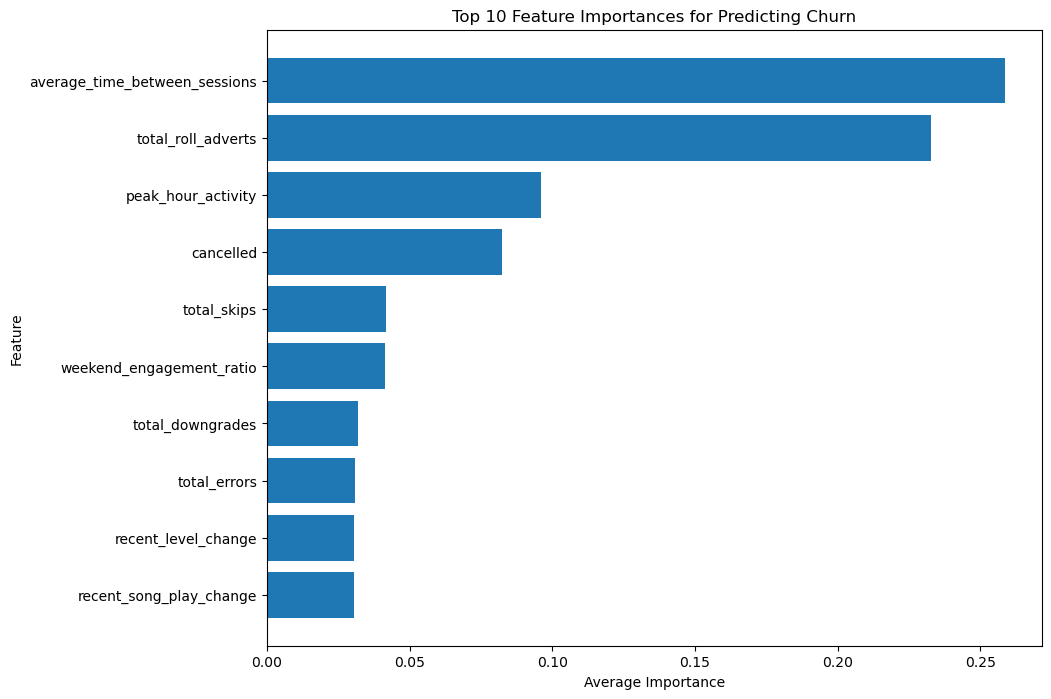

In [181]:
# Get feature importances and corresponding indices of used features
rf_importances = best_rf.feature_importances_
xgb_importances = best_xgb.feature_importances_

# Retrieve the used features (assuming the models discarded two features)
feature_names_reduced = feature_data_reduced.columns[:len(rf_importances)]

# Average the feature importances
ensemble_importances = (rf_importances + xgb_importances) / 2

# Create a DataFrame to organize and sort the features by importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names_reduced,
    'Importance': ensemble_importances
}).sort_values(by='Importance', ascending=False)

# Plot the top features
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 8))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10))
plt.gca().invert_yaxis()  # Invert y-axis to show highest importance at the top
plt.xlabel('Average Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances for Predicting Churn')
plt.show()


### Conclusion

In conclusion, we evaluated four base models—**Logistic Regression, Random Forest, XGBoost, and SVM**—to predict user churn. Among these, **XGBoost and Random Forest** emerged as the top performers, showing the highest potential for accurately identifying churned users. Although we optimized both models individually, neither could achieve a churn prediction accuracy above 50%. To enhance performance, we implemented a **voting ensemble approach** that combined XGBoost and Random Forest. This ensemble strategy improved our model's predictive accuracy to **67%**, making it our best solution for churn prediction.

The chart above highlights the **top feature importances** identified by our ensemble model. The most influential predictors for churn included:

1. **Average Time Between Sessions**
2. **Total Roll Adverts**
3. **Peak Hour Activity**

These insights provide valuable information for understanding and addressing user churn, offering actionable indicators that could help in developing strategies to retain users more effectively.


In [224]:
feature_data_reduced.head()

,userId,total_errors,total_roll_adverts,average_time_between_sessions,time_since_registration,cancelled,total_skips,discovery_engagement_ratio,level_skip_interaction,recent_level_change,recent_session_activity_change,recent_song_play_change,total_downgrades,avg_session_duration,weekend_engagement_ratio,weekday_engagement_ratio,peak_hour_activity,ad_interaction_rate,skip_percentage
0,30,0.0,1.0,4617.843828,51,0,4.0,0.031204,0.005944,0.0,0.0,0.0,0.0,59502.832704,0.098113,0.901887,4,0.000000,0.005944
1,9,3.0,25.0,1585.647992,64,0,27.0,0.041014,0.010067,0.0,29.0,2009.0,1.0,36152.586808,0.131612,0.868388,17,0.083333,0.010067
2,74,1.0,14.0,654.306451,44,1,2.0,0.037594,0.000000,0.0,-31.0,-2549.0,0.0,10115.807487,0.000000,0.000000,6,0.074866,0.015038
3,54,0.0,3.0,21935.626728,160,0,0.0,0.030769,0.000000,0.0,0.0,62.0,0.0,38612.376147,0.000000,0.000000,16,0.000000,0.000000
4,4,0.0,9.0,2264.428571,22,1,0.0,0.000000,0.000000,0.0,-2.0,-144.0,0.0,11405.923077,0.000000,0.000000,13,0.115385,0.000000


In [237]:
# Get the indices of churned users
churned_indices = y_test[y_test == 1].index

# Filter for churned users in the test set
churned_y_test = y_test.loc[churned_indices]
churned_y_pred = pd.Series(y_pred, index=y_test.index).loc[churned_indices]

# Identify churned users that were predicted correctly (true positives)
correctly_predicted_churned = churned_y_test[churned_y_test == churned_y_pred]

# Filter the corresponding features for correctly predicted churned users
correctly_predicted_churned_data = X_test.loc[correctly_predicted_churned.index]



In [230]:
import pandas as pd

# Convert predictions to a Series for easier indexing
y_pred_series = pd.Series(y_pred, index=y_test.index)

# Identify true positives (correctly predicted churned users)
true_positives_indices = y_test[(y_test == 1) & (y_pred_series == 1)].index
true_positives_data = X_test.loc[true_positives_indices]

# Identify true negatives (correctly predicted non-churned users)
true_negatives_indices = y_test[(y_test == 0) & (y_pred_series == 0)].index
true_negatives_data = X_test.loc[true_negatives_indices]

# Compare feature averages between true positives and true negatives
comparison_df = pd.DataFrame({
    'Feature': X_test.columns,
    'True Positives (Churned Avg)': true_positives_data.mean(),
    'True Negatives (Non-Churned Avg)': true_negatives_data.mean()
}).set_index('Feature')

print("Feature Comparison between Correctly Predicted Churned and Non-Churned Users:")
print(comparison_df)


Feature Comparison between Correctly Predicted Churned and Non-Churned Users:
                                True Positives (Churned Avg)  \
Feature                                                        
total_errors                                        0.444444   
total_roll_adverts                                 32.888889   
average_time_between_sessions                    3189.984022   
time_since_registration                            46.444444   
total_skips                                        10.777778   
discovery_engagement_ratio                          0.049073   
level_skip_interaction                              0.008012   
recent_level_change                                -0.444444   
recent_session_activity_change                     -6.111111   
recent_song_play_change                          -445.111111   
total_downgrades                                    0.333333   
avg_session_duration                            20104.373354   
weekend_engagement_ratio  

### Most Significant Feature Comparison between Correctly Predicted Churned and Non-Churned Users

| Feature                        | Churned Avg | Non-Churned Avg | Difference |
|--------------------------------|----------------------|--------------------------|------------|
| **total_roll_adverts**         | 32.89               | 14.67                    | +18.22     |
| **average_time_between_sessions (Hours)** | 0.89               | 3.26                     | -2.37      |
| **time_since_registration (days)**    | 46.44               | 82.79                    | -36.35     |
| **avg_session_duration (Hours)**       | 5.59                | 8.96                     | -3.37      |
| **weekend_engagement_ratio**   | 0.31                | 0.18                     | +0.13      |
| **weekday_engagement_ratio**   | 0.69                | 0.61                     | +0.08      |
| **peak_hour_activity**         | 15.89               | 12.79                    | +3.10      |
| **ad_interaction_rate**        | 0.10                | 0.07                     | +0.03      |
| **skip_percentage**            | 0.02                | 0.01                     | +0.01      |

These values reveal significant behavioral differences between users likely to churn and those likely to remain:
- **total_roll_adverts**: Churned users see a significantly higher number of ads, possibly leading to frustration.
- **average_time_between_sessions**: Churned users tend to have shorter gaps between sessions, suggesting frequent but brief engagements.
- **time_since_registration**: Churned users have been registered for a shorter period, indicating possible dissatisfaction early in the user journey.
- **avg_session_duration**: Non-churned users have longer average session times, suggesting higher engagement levels.
- **weekend_engagement_ratio**: Churned users have a higher engagement ratio on weekends.
- **peak_hour_activity**: Churned users tend to be active later in the day, possibly pointing to specific usage habits.
- **ad_interaction_rate** and **skip_percentage**: Higher ad interaction and skip rates among churned users, indicating possible dissatisfaction with the content and experience.

Understanding these indicators can guide targeted strategies to enhance user retention and reduce churn.


### Conclusion and Next Steps for Sparkify

This project provided an in-depth analysis of user behavior patterns that influence churn in the Sparkify dataset. By identifying the top predictive features and interpreting their significance, we have gained valuable insights into the behaviors and pain points that differentiate loyal users from those likely to leave the platform. The findings suggest that frequent but brief engagement, high ad exposure, and elevated skip rates are clear signals of potential churn. Furthermore, the disparity in engagement patterns, particularly during weekends, hints at differing user motivations that Sparkify can leverage to tailor retention strategies.

### Key Takeaways

1. **Engagement Frequency Matters**: Users with longer average intervals between sessions are more likely to stay, indicating that promoting meaningful and satisfying interactions is more effective than encouraging frequent but shallow engagement.
   
2. **Impact of Ad Exposure**: Excessive ad exposure correlates with higher churn risk, suggesting that ads may hinder user satisfaction, particularly for free-tier users. Balancing ad frequency and relevance will be critical for improving the free-tier experience.

3. **Content Satisfaction**: High skip rates among churned users reflect dissatisfaction with content recommendations. Enhancing personalization and providing greater control over content selection could significantly improve user retention.

4. **Varied User Routines**: Users who treat Sparkify as a weekend-only platform may view it as supplementary to other streaming services or entertainment activities. Encouraging weekday engagement can help transition these users into more consistent, habitual usage.

### Recommendations for Sparkify’s Next Steps

With these findings, Sparkify has an actionable roadmap to refine its user experience and retention strategies. Here’s how the company can leverage this analysis to build a more loyal user base:

1. **Personalized Engagement Campaigns**: Use data-driven strategies to identify users showing signs of potential churn—those with shorter average session durations or high ad interaction rates. Personalized notifications, exclusive content, and timely nudges (e.g., reminders or playlist recommendations) can re-engage these users effectively.

2. **Optimize Ad Experience**: Consider alternative ad models or frequency adjustments for high-risk users. Testing reduced ad loads or offering ad-free trial periods may encourage upgrades to the premium tier and improve overall satisfaction among free users.

3. **Enhance Content Recommendation Algorithms**: High skip rates highlight a need for improvement in content recommendations. Incorporate user feedback loops, leverage machine learning models to analyze preferences, and allow users more customization to increase satisfaction and reduce churn.

4. **Targeted Weekend Campaigns**: For users who primarily engage on weekends, create special playlists, events, or weekend-only incentives to reinforce positive experiences. Additionally, explore weekday engagement initiatives, such as "Monday Mix" or "Midweek Discoveries," to encourage habitual use.

5. **Monitor User Tolerance for Errors**: Since non-churned users experience slightly more errors but still remain engaged, Sparkify can explore user tolerance for minor issues. Collecting and analyzing feedback on user experience can help prioritize and address significant pain points without over-focusing on minor inconveniences.

### Final Thoughts

By focusing on meaningful, data-driven actions, Sparkify can better address the needs of its users, encouraging sustained engagement and fostering a loyal user base. The insights from this analysis provide Sparkify with the tools to make informed, proactive changes that enhance user satisfaction and minimize churn. The next steps include implementing these targeted strategies and continuously monitoring their effectiveness. By doing so, Sparkify can not only reduce churn but also position itself as a platform that genuinely prioritizes its users' listening experience.

The findings and recommendations outlined in this project serve as a foundation for Sparkify to evolve its product strategy. As the platform grows, continued exploration of user behavior patterns, paired with iterative testing of engagement strategies, will ensure that Sparkify remains adaptive and resilient in a competitive streaming landscape.
